In [461]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats
import env_params

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch



# Force reload modules  ## CAN BE REMOVED WHEN DONE
import importlib
importlib.reload(visualization)
importlib.reload(stats)
importlib.reload(data_processing)


# Suppress pandas future-warning about categorical dtypes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [240]:
# Load the parameters of the unity environment from a separate file
importlib.reload(env_params)
import env_params
from env_params import HALLWAY_DIMS as hw_dims
from env_params import get_hallway_layouts, Boxes

hallways = env_params.get_hallway_layouts()
segmentLength = hw_dims['segmentLength']
hwLength = len(hallways)*hw_dims['segmentLength']
box_locations = env_params.BOX_LOCATIONS

## Load data

In [3]:
subjects = data_processing.SUBJECTS_EXP1
exp_filenames, clbr_filenames = data_processing.get_filenames(subjects=subjects, 
                                                              data_keys = ['TrialConfigRecord','EngineDataRecord']) # No calibration performed in exp1, so clbr_filenames returned empty
exp_data = data_processing.load_data_from_filenames(exp_filenames, downsample=1)
# data_processing.preprocess_data(exp_data, convert_quaternions=False, expand_columns=['XRHeadPos', 'XROriginPos'])

In [4]:
data_processing.preprocess_data(exp_data, convert_quaternions=False, expand_columns=['XRHeadPos', 'XROriginPos'])

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:04<00:00, 122.41s/it]


In [212]:
###### Fetch the Unity engine data, and the trial configs which are saved after each trial
eng_data = exp_data['EngineDataRecord'].copy()
trc_data = exp_data['TrialConfigRecord'].copy()

# Add some basic missing collumns 
eng_data = eng_data.rename(columns={'SecondsSinceTrialStart': 'SecondsSinceStartRecording'})
eng_data['Displacement'] = eng_data[['XRHeadPosZ', 'XRHeadPosX']].apply(np.linalg.norm, axis=1).diff()
eng_data['Speed'] = abs(eng_data.Displacement / (eng_data.TimeStamp.diff() * 1e-7))
eng_data['StartPosX'] = eng_data.Hallway.replace(env_params.START_POS_X)
eng_data['StartPosZ'] = eng_data.Hallway.replace(env_params.START_POS_Z)

### Remove invalid data

Some data files contain frames with wrong timestamp (increasing with respect to the previous one). This is because in some cases the writing of the previous datafile was not finished before the next trial was started. The faulty frames can be easily identified using the time stamps.

The valid frames adhere to 3 criteria:
- the Timestamps are increasing
- there is not a large gap between timestamps (long frame duration)
- the head position is inside the correct hallway that was used for the current trial (only implemented as sanity check)

In [371]:
def detect_invalid_frames(data, verbose=True):
    """Find incongruent timestamps in the engine data and mark frames as invalid. 
    Note: the invalid frame masks are added inplace as new columns in the input dataframe.
    returns: trial-indexed dataframe indicating which trials contain invalid frames.
    """
    # Mark as invalid if timestamp is not larger than previous frame
    data['InvalidTimeStamp'] = data.TimeStamp < data.groupby('TrialIdentifier').TimeStamp.cummax()
    
    # Mark the first 0.1 seconds of each recording as invalid.
    first_frames = data.SecondsSinceStartRecording < 0.1
    data['InvalidFrame'] = data.InvalidTimeStamp | first_frames
    
    # From the remaining valid frames...
    msk = ~data.InvalidFrame
    
    # ... Detect frames where the head location is outside of the hallway (just as sanity check, should be 0)
    data['InvalidLocation'] = False
    data.loc[msk, 'InvalidLocation'] = (data.loc[msk].XRHeadPosX - data.loc[msk].StartPosX).abs() > 2
    
    # ... Detect long frame durations (>0.5)
    frame_duration = (data.groupby('TrialIdentifier').TimeStamp.shift(-1) - data.TimeStamp) * 1e-7
    data['InvalidFPS'] = False
    data.loc[msk,'InvalidFPS'] = frame_duration.loc[msk] > 1. #0.5
    low_fps_mask = data.groupby('TrialIdentifier').InvalidFPS.any()
    low_fps_trials = low_fps_mask.loc[low_fps_mask].index
    # data.loc[data.TrialIdentifier.isin(low_fps_trials), 'InvalidFrame'] = True # Mark entire trial as invalid
    
    #### Output a summary of the data cleaning
    indep_vars = ['Subject', 'Block', 'RelativeTrialNumber', 'GazeCondition', 'Hallway']
    columns = ['InvalidLocation','InvalidTimeStamp','InvalidFPS']
    valid_mask = data.groupby(['TrialIdentifier'] + indep_vars)[columns].any().reset_index(indep_vars)
    valid_mask['DeletedFrames'] = data.groupby(['TrialIdentifier']).InvalidFrame.sum()
    
    invalid_location_trials = valid_mask.loc[valid_mask.InvalidLocation].index
    invalid_timestamp_trials = valid_mask.loc[valid_mask.InvalidTimeStamp].index
    low_fps_trials = valid_mask.loc[valid_mask.InvalidFPS].index

    if verbose:
        print(f"Marked the first 0.1 seconds of each recording ({first_frames.sum()} frames in total, all trials) as invalid.")
        print(f"Marked {data.InvalidTimeStamp.sum()} frames (from {len(invalid_timestamp_trials)} trials) as invalid, timestamp difference <0")
        print(f"Marked an additional {data.InvalidLocation.sum()} frames (from {len(invalid_location_trials)} trials) as invalid, head position outside hallway")
        print(f"{data.InvalidFPS.sum()} frames were detected with a frame duration > 0.5s, the {len(low_fps_trials)} corresponding trials are marked as invalid.")
        print(f"Total of {data.InvalidFrame.sum()} frames were marked as invalid.")
        display(valid_mask.groupby('Subject')[columns].sum())
    return valid_mask
trial_validity = detect_invalid_frames(eng_data, verbose=False)
eng_data_clean = eng_data.loc[~eng_data.InvalidFrame].copy()

## Data Analysis

In [373]:
def dist2rect(rect, x,y):
    """Calculate the distance between rectangle <rect> and points <x,y>.
    params x, y: numpy arrays of length N with the coordinates of the points
    param rect: numpy array of shape(4,2), containing the corner coordinates of the rectangle
    returns np.array of length N containing the shortes distance from the points to the rectangle"""
    dx = np.max(np.stack([rect[:,0].min() - x,
                          np.zeros_like(x),
                          x - rect[:,0].max()]), axis=0)
    dy = np.max(np.stack([rect[:,1].min() - y,
                          np.zeros_like(x),
                          y - rect[:,1].max()]), axis=0)
    dist = np.sqrt(dx*dx + dy*dy)
    return np.nan_to_num(dist, nan=np.inf)

In [374]:
def trial_endpoint_analyis(data:pd.DataFrame, only_collisions_in_zone=False):  
    """ Calculate trial endpoints (collisions, duration) from the raw engine data.
    Note: performs inplace operations on the input dataframe!
    1. Remap the raw head location to new x and y coordinates (for horizontal plotting)
    2. Calculate the trial duration (time from start to finish)
    3. Calculate the number of collisions (defined as proximity with an obstacle < player radius)

    param data (pandas DataFrame]): the Unity engine data (all frames of all trials)
    param only_collisions_in_zone (bool): set True to ignore backward collisions (obstacle in previous zone)  
    returns trial-indexed pandas DataFrame with the data endpoints per trial (collisions, trial duration, etc..)
    """
    ###### 1. Get path 
    # # Get path (displayed horizontally: forward becomes x,  left & right becomes y)
    # Remove offset in sideways direction (different for each hallway)
    data['y'] = (data.XRHeadPosX - data.StartPosX).copy()
    # Center around 0, and invert direction (in Unity right is positive, left is negative)
    data['y'] = -1 * data.y + hw_dims['hwWidth'] / 2     
    data['x'] = (data.XRHeadPosZ + data.StartPosZ).copy()
     
    ###### 2. Calculate Trial Durations
    # Detect every crossing of the start line (direction: one  for -> and minus one for <-)
    trial_idx = data.TrialIdentifier # For grouping data per trial
    data['StartEvent'] = (data.x >= hw_dims['startLine']).astype(int).groupby(trial_idx).diff() 
    data['StartEventCount'] = (data.StartEvent > 0).groupby(trial_idx).cumsum()
    
    # Every frame after the last start line crossing in positive direction is marked as 'started'
    data['TotalStartEvents'] = data.groupby(trial_idx).StartEventCount.max().loc[trial_idx].values
    
    ## Mark the start and finish of each trial
    # start: Either first time start line was crossed, or the last time the start line was crossed
    # finish: the first time that the finish line was crossed
    data['StartedTrial'] = data.StartEventCount > 0 # True for each frame after first start in trial (first time start line was crossed ->)
    # data['StartedTrial'] = data.StartEventCount == data.TotalStartEvents.values # True for each frame after last 'start' event
    data['FinishedTrial'] = (data.StartedTrial & (data.x >= hw_dims['finishLine'])).groupby(trial_idx).cumsum() > 0 # Mark all frames as finished after the first time the finish line is reached 
    data['InsideTrial'] = False # Mark the frames that are counted as inside the trial window
    data.loc[data.StartedTrial & ~data.FinishedTrial, 'InsideTrial'] = True
    unfinished = ~data.groupby('TrialIdentifier').FinishedTrial.transform('max')
    data.loc[unfinished, 'InsideTrial'] = False
    
    # Output Data
    never_started = data.groupby('TrialIdentifier')['StartEventCount'].max() == 0
    never_finished = data.groupby('TrialIdentifier')['FinishedTrial'].max() == False
    total_start_events = data.groupby('TrialIdentifier')['StartEventCount'].max()
    
    # Calculate the trial duration
    start_frames = data.loc[data.InsideTrial].groupby('TrialIdentifier').first() # First frame after start of trial
    final_frames = data.loc[data.InsideTrial].groupby('TrialIdentifier').last() # Last frame of each trial
    trial_duration = (final_frames.TimeStamp - start_frames.TimeStamp) * 1e-7 # convert to seconds 
    
    ###### 3. Calculate Collisions    
    # Get the obstacle in the zone (segment) that the player is currently visiting
    data['PlayerZone'] = (data.x  // hw_dims['segmentLength']).astype(int)
    
    # The zone (segment) of the closest box (equals player zone, shifted by half a zonelength)
    data['ClosestBoxZone'] = (data.x - hw_dims['segmentLength'] / 2) // hw_dims['segmentLength']
    data['ClosestBoxZone'] = data.ClosestBoxZone.clip(0,22).astype(int)

    # Detect collisions based on the box locations an
    if only_collisions_in_zone:
        # Look for collisions in the player zone (only collisions with obstacles in the current zone)
        for hallway_name, data_ in data.groupby('Hallway'):
            data.loc[data_.index,'Obstacle'] = data_.PlayerZone.replace(hallways[hallway_name]).values
        
        # Loop over all obstacle variants
        data['ObstacleID'] = data.Obstacle.apply(lambda x: x.value) # replace with value, pandas can't group by enums...
        for obstacle_id, data_ in data.groupby('ObstacleID'):
            rect1, rect2 = box_locations[Boxes(obstacle_id)]
            x = (data_.x % hw_dims['segmentLength']).values # only look in current player zone (segment)
            y = data_.y.values
            min_dist = np.min(np.stack([dist2rect(rect1, x, y),
                                        dist2rect(rect2, x, y)]), axis=0)
            data.loc[data_.index, 'DistToObstacle'] = min_dist
    else:
        # Look for collisions in the zone of the closest box (which can be in the previous zone)
        for hallway_name, data_ in data.groupby('Hallway'):
            data.loc[data_.index,'Obstacle'] = data_.ClosestBoxZone.replace(hallways[hallway_name]).values
        
        # Loop over all obstacle variants
        data['ObstacleID'] = data.Obstacle.apply(lambda x: x.value) # replace with value, pandas can't group by enums...
        for obstacle_id, data_ in data.groupby('ObstacleID'):
            rect1, rect2 = box_locations[Boxes(obstacle_id)]
            # Shift zone (segment) of interest to [-0.5 to 0.5]:
            x = ((data_.x - 0.5 * hw_dims['segmentLength']) % hw_dims['segmentLength']).values + 0.5 * hw_dims['segmentLength']
            y = data_.y.values
            min_dist = np.min(np.stack([dist2rect(rect1, x, y),
                                        dist2rect(rect2, x, y)]), axis=0)
            data.loc[data_.index, 'DistToObstacle'] = min_dist

    # In each trial, Count the number of zones with a collision 
    data['Collision'] = data.DistToObstacle < hw_dims['pRadius']
    data['InsideBox'] = data.DistToObstacle == 0
    grouped_by_zone = data.loc[data.InsideTrial].groupby(['TrialIdentifier', 'ClosestBoxZone'])
    any_colisions_per_zone = grouped_by_zone[['Collision']].any()
    collisions_per_trial = any_colisions_per_zone.groupby('TrialIdentifier').sum()['Collision']

    # # Frontal collisions are collisions when the player walks into the front-side of the box
    # x_rel = data.x % hw_dims['segmentLength'] # relative position in the zone
    # data['FrontalCollision'] = data.Collision & (x_rel<1.7) & (x_rel>1)
    # data['FrontalCollision'] = data['InsideBox'] | data['FrontalCollision']
    # grouped_by_zone = data.loc[data.InsideTrial].groupby(['TrialIdentifier', 'ClosestBoxZone'])
    # frt_colisions_per_zone = grouped_by_zone[['FrontalCollision']].any()
    # frt_collisions_per_trial = frt_colisions_per_zone.groupby('TrialIdentifier').sum()['FrontalCollision']
    
    ###### 4. Copy to output dataframe with results
    indep_vars = ['Subject', 'Block', 'RelativeTrialNumber', 'GazeCondition', 'Hallway']
    
    trial_results = data.groupby(['TrialIdentifier']).first()
    
    output_data = {'NeverStarted': never_started,
                   'NeverFinished': never_finished,
                   'TotalStartEvents': total_start_events,
                   'TotalCollisions': collisions_per_trial,
                   # 'FrontalCollisions': frt_collisions_per_trial,
                   'TrialDuration': trial_duration}
                   
    for result_name, result in output_data.items():
        trial_results.loc[result.index, result_name] = result.values

    endpoints = [*output_data.keys()]
    return trial_results[indep_vars + endpoints]

In [375]:
# Calculate trial endpoints
trial_results = trial_endpoint_analyis(eng_data_clean)
columns = ['NeverStarted', 'NeverFinished', 'TotalStartEvents']
trial_validity[columns] = trial_results[columns]
# raw_results = trial_endpoint_analyis(eng_data)

# Save trial validity and results
# trial_validity.to_csv('out/inclusion_mask.tsv', sep='\t', index=True)
# trial_results.to_csv('out/mobility_trial_endpoints.tsv', sep='\t', index=True)

## Performance per subject

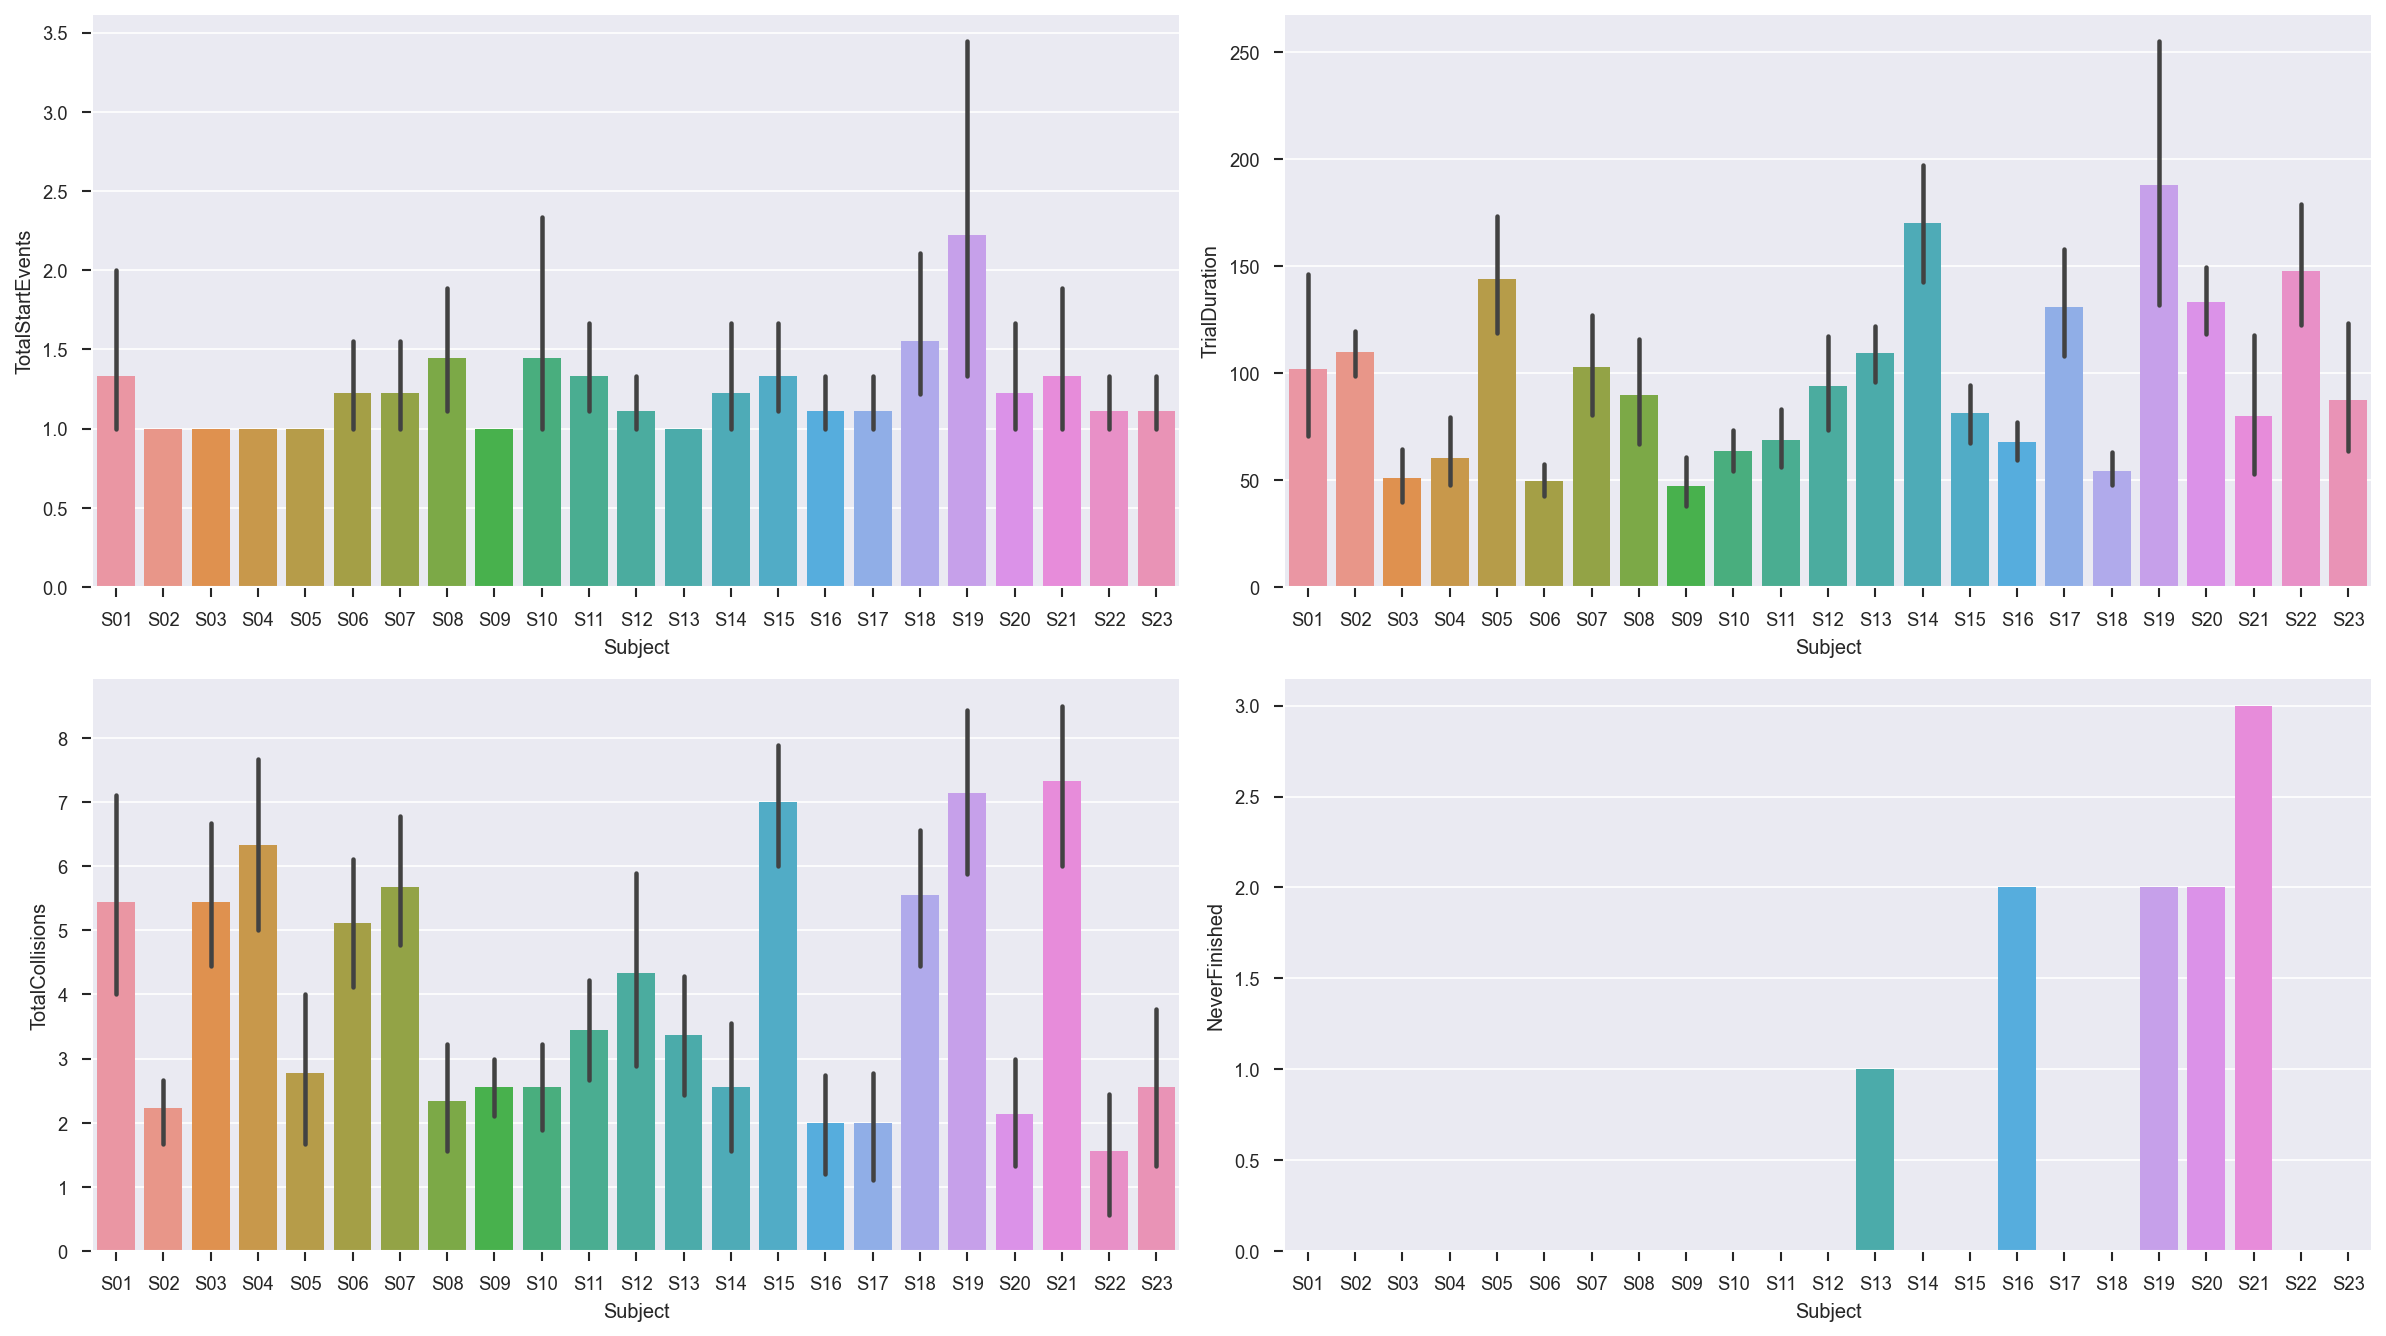

In [403]:
visualization.set_figurestyle()
fig, axs = plt.subplots(2,2, figsize=(16,9), dpi=150)
sns.barplot(data=trial_results, y='TotalStartEvents', x='Subject',ax=axs[0][0])
sns.barplot(data=trial_results, y='TrialDuration', x='Subject', ax=axs[0][1])
sns.barplot(data=trial_results, y='TotalCollisions', x='Subject', ax=axs[1][0])
sns.barplot(data=trial_results.groupby('Subject').sum().reset_index(), y='NeverFinished', x='Subject', ax=axs[1][1])
plt.tight_layout()

### Example parcours

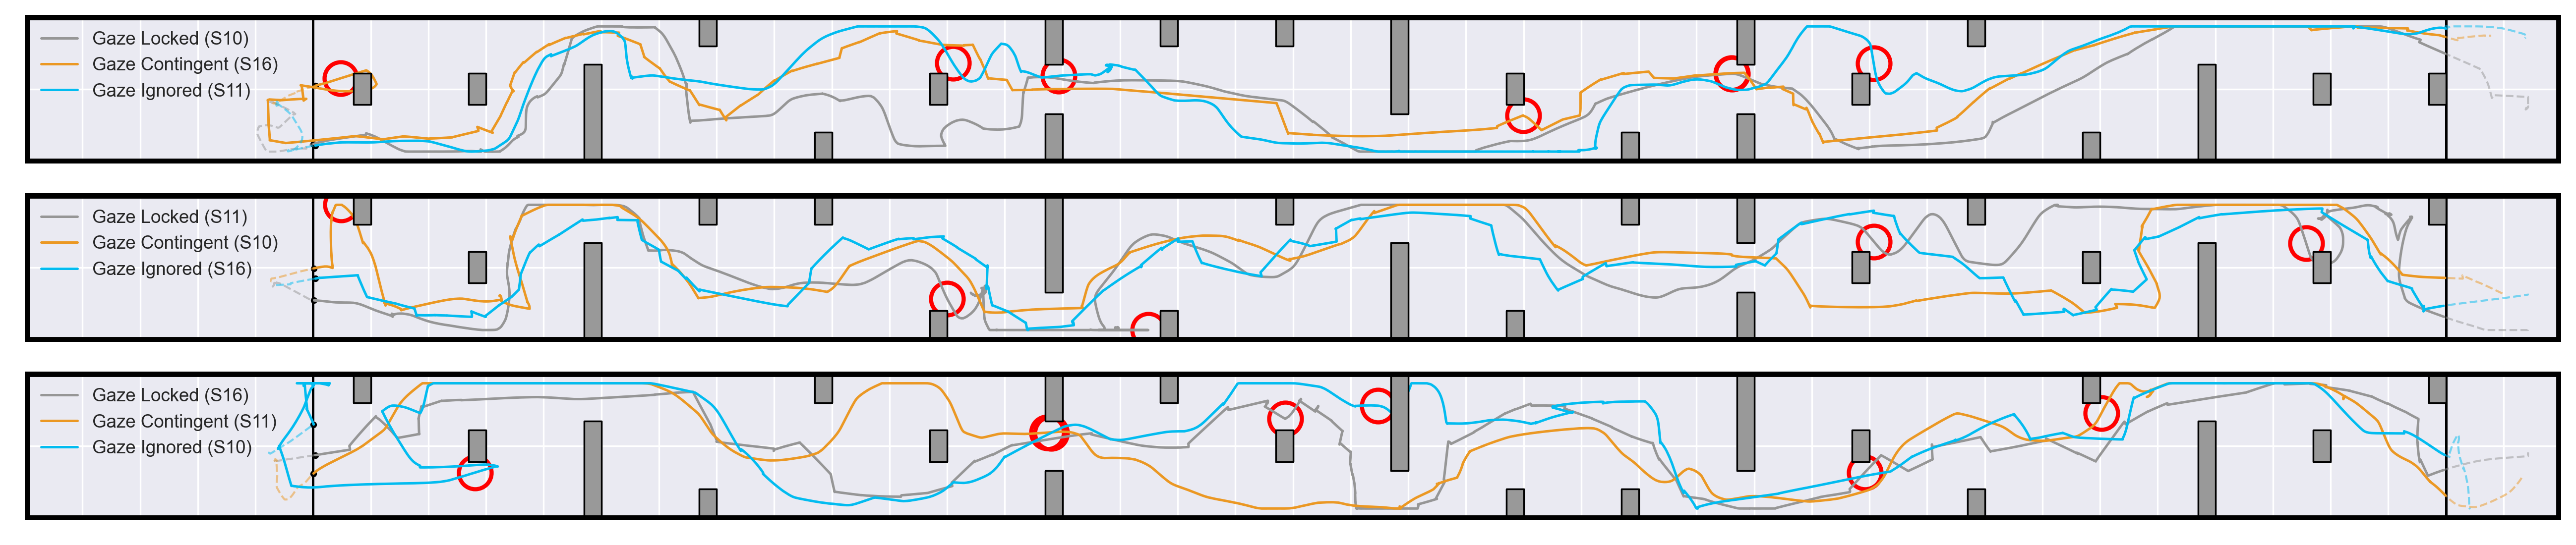

In [482]:
visualization.set_figurestyle()
trials = ['S10B2T0', 'S11B2T2', 'S16B2T2', 'S10B2T1', 'S11B2T0', 'S16B2T0', 'S10B2T2', 'S11B2T1', 'S16B2T1']
visualization.plot_mobility_trajectories(data=eng_data_clean, 
                                         trials=trials,
                                         hue='GazeCondition',
                                         cmap=visualization.COLORMAP,
                                         hue_order=visualization.ORDERED_CONDITIONS)

plt.savefig('out/mobility_plot.png')

## Statistical Analysis

In [743]:
# # load data 
# trial_results = pd.read_csv('out/mobility_analysis_trial_endpoints.tsv',sep='\t')
# trial_results = trial_results.set_index(['TrialIdentifier','Subject','GazeCondition'])
# trial_validity = pd.read_csv('out/inclusion_mask.tsv', sep='\t')

In [365]:
indep_vars = ['Subject', 'Block', 'Hallway', 'GazeCondition']
endpoints = ['TotalCollisions', 'FrontalCollisions', 'TrialDuration']


valid_mask = ~trial_validity[['InvalidFPS', 'NeverStarted', 'NeverFinished']].any(axis=1)
# valid_mask = valid_mask.groupby(trial_validity.Subject).transform('sum') >7

# valid_mask = ~trial_validity[['InvalidFPS']].any(axis=1)


# valid_mask = np.ones(len(trial_results)).astype(bool)
valid_results = trial_results.loc[valid_mask].reset_index()
print(f'excluding {(~valid_mask).sum()} trials')

# Average over subjects 
avg = stats.average(valid_results, y=endpoints, group='Subject', x='GazeCondition')

# Normality test
normality = stats.normality_test(avg, endpoints=endpoints)
non_normal_endpoints = [y for y in endpoints if normality.loc['AnyNonNormal', y]]
normal_endpoints = [y for y in endpoints if not normality.loc['AnyNonNormal', y]]
display('Normality test:',  stats.style(normality))

# Non-parametric tests
results_wilcoxon = pd.DataFrame()
if non_normal_endpoints:
    results_wilcoxon = stats.paired_test(avg, group='Subject', endpoints=non_normal_endpoints, test='Wilcoxon')
    display('Results Wilcoxon:', stats.style(results_wilcoxon, alpha=0.05/3))

# Parametric tests
results_t_test = pd.DataFrame()
if normal_endpoints:
    results_t_test = stats.paired_test(avg, group='Subject', endpoints=normal_endpoints, test='t-test')
    display('Results t-test:', stats.style(results_t_test, alpha=0.05/3))

# All Results
stat_results = pd.concat([results_wilcoxon, results_t_test], axis=1)[endpoints]
# display('Merged results:', stats.style(stat_results, alpha=0.05/3))

excluding 12 trials


'Normality test:'

,TotalCollisions,FrontalCollisions,TrialDuration
GazeAssistedSampling,0.124066,0.006065,0.076557
GazeIgnored,0.110580,0.020473,0.014027
SimulationFixedToGaze,0.040606,0.058945,0.099522
AnyNonNormal,True,True,True


C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


'Results Wilcoxon:'

,TotalCollisions,FrontalCollisions,TrialDuration
Comparison,,,
Gaze Locked <> Gaze Contingent,0.042958,0.056253,0.000552
Gaze Contingent <> Gaze Ignored,0.409601,0.205870,0.445200
Gaze Locked <> Gaze Ignored,0.001187,0.000810,0.000849


##### Save output

In [342]:
# # # Save results
# avg.to_csv('out/mobility_analysis_averaged_endpoints.tsv', sep='\t')
# normality.to_csv('out/mobility_analysis_normality_test.tsv', sep='\t')
# stat_results.to_csv('out/mobility_analysis_paired_testing.tsv', sep='\t')

# # # import dataframe_image as dfi
# # dfi.export(stat_results, 'out/stats_mobility_analysis.png')

### Visualization

In [483]:
# # Load data
# avg = pd.read_csv('out/gaze_analysis_averaged_endpoints.tsv', sep='\t')
# normality = pd.read_csv('out/gaze_analysis_normality_test.tsv', sep='\t')
# stat_results = pd.read_csv('out/gaze_analysis_paired_testing.tsv', sep='\t').set_index('Comparison')

In [484]:
stars = stat_results.applymap(stats.count_significance_stars)
stars

,TotalCollisions,FrontalCollisions,TrialDuration
Comparison,,,
Gaze Locked <> Gaze Contingent,n.s.,n.s.,**
Gaze Contingent <> Gaze Ignored,n.s.,n.s.,n.s.
Gaze Locked <> Gaze Ignored,**,**,**


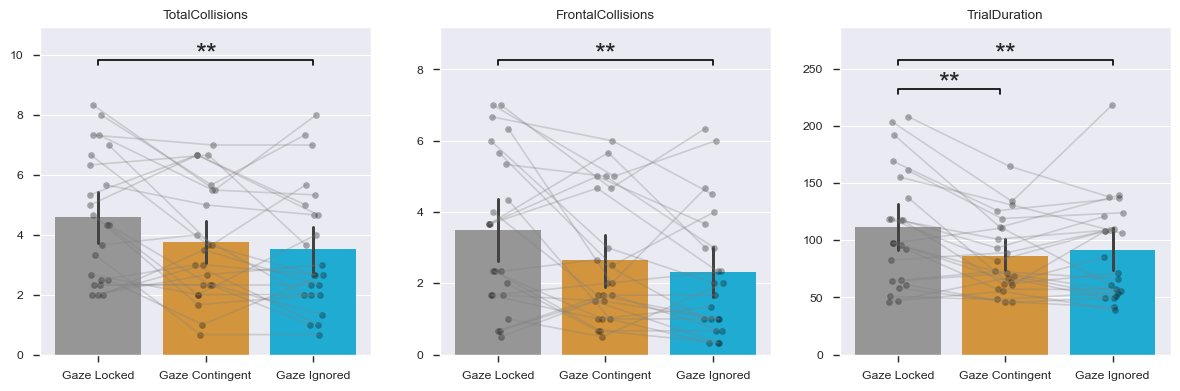

In [485]:
# endpoints = ['GazeVarianceEyes', 'AvgVelocityEyes', 'AvgVelocityHead',] # , 'TotalDisplacementEyes', 'TotalDisplacementHead'] 
# titles = ['Gaze Variance',  'Eye Velocity', 'Head Velocity']
# y_lbls = ['Variance $(Deg/s)^2$', 'Velocity $(Deg/s)$', 'Velocity $(Deg/s)$']

# endpoints = ['TrialDuration', 'FrontalCollisionCount']

# titles = ['Trial Duration',  'Collisions']
# y_lbls = ['Duration $(s)$', 'Count']

titles = endpoints
y_lbls = ['',] * len(endpoints)


visualization.set_figurestyle()
fig,axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, group = 'Subject', axs=axs, fig=fig)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.tight_layout()

for i, ax in enumerate(axs.flatten()):
    axs[i].set(title=titles[i], ylabel=y_lbls[i])
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)

# plt.savefig('out/mobility_endpoints.png')
# visualization.add_panel_index(axs[0], 'D')

#### More visualizations

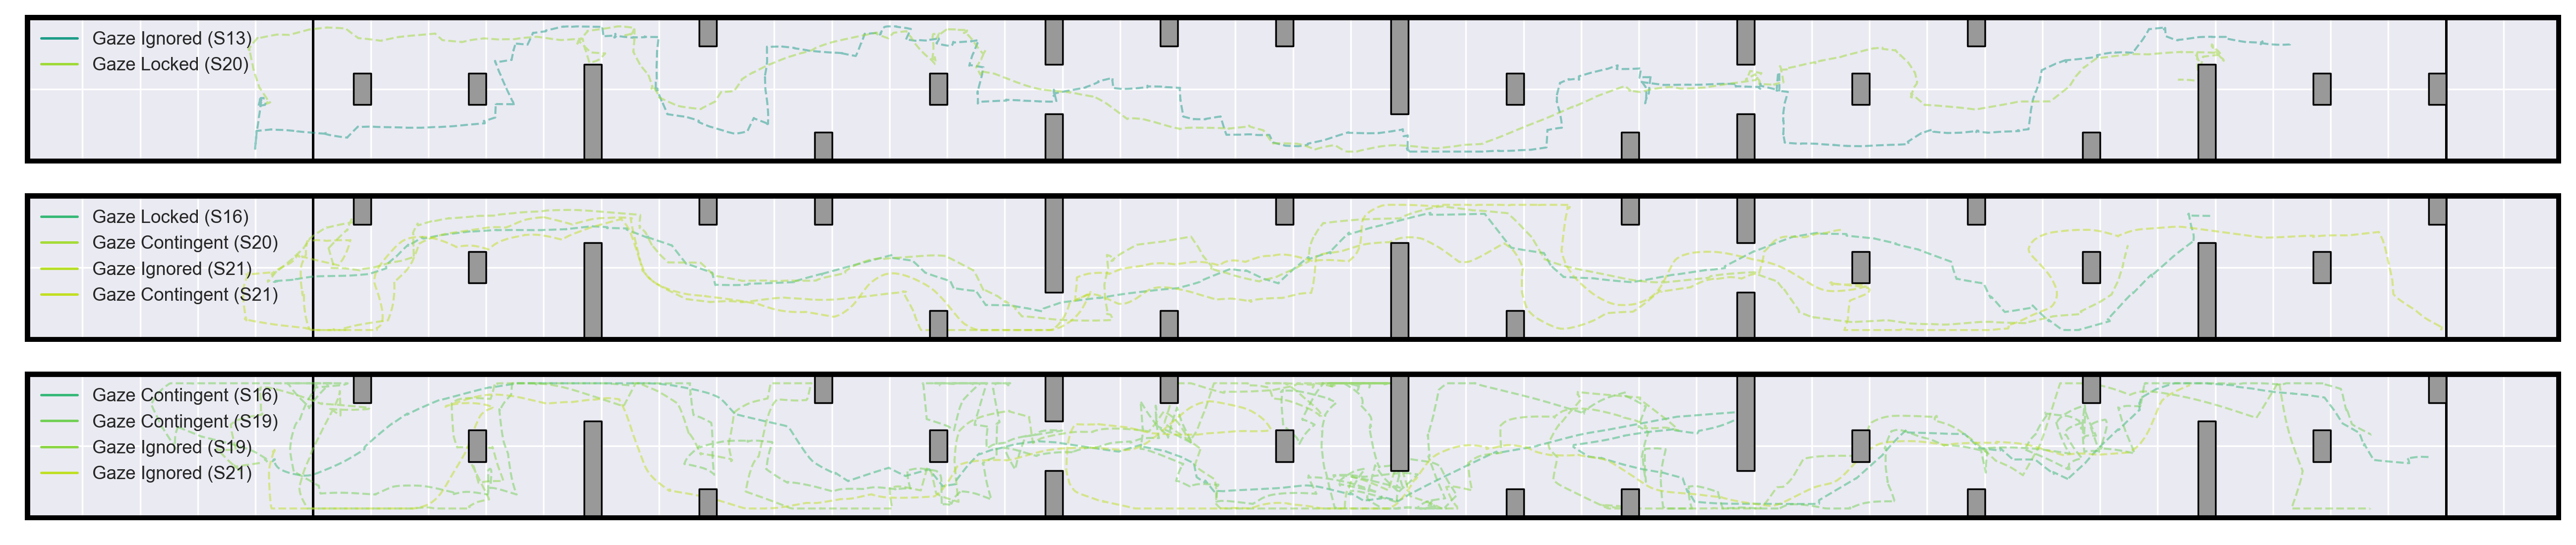

In [506]:
importlib.reload(visualization)
# subjects = ['S16']
# trials = eng_data.loc[eng_data.Subject.isin(subjects)].TrialIdentifier.unique()


# trials = ['S19B0T0','S19B2T2',]# 'S19B1T1', 'S19B1T2',]
       #'S19B2T0', 'S19B2T1', 'S19B2T2']
    
# trials = unfinished_trials
# trials = almost_finished_trials
# trials = late_start_trials
# trials = wrong_start_trials

# trials = [ #['S01B0T1', 'S03B2T1', 'S04B1T1', 'S05B0T2', 'S05B2T1', 'S06B0T0',
#        'S08B2T0', 'S09B2T2', 'S10B2T2', ] #'S11B0T1', 'S11B0T2', 'S13B2T1',
# #        'S13B2T2', 'S14B1T0', 'S15B0T2', 'S15B1T0', 'S16B1T1', 'S16B1T2',
# #        'S16B2T0', 'S16B2T1', 'S17B1T2', 'S18B0T0', 'S18B1T1', 'S18B1T2',
# #        'S18B2T1', 'S18B2T2', 'S19B0T0', 'S19B2T0', 'S21B0T0', 'S21B1T1',
# #        'S21B2T1', 'S21B2T2']

# trials = ['S01B0T1']

# for subject in ['S02', 'S09', 'S18', 'S19', 'S20', 'S21']:
#     trials = data_proc.loc[data_proc.Subject==subject].TrialIdentifier.unique()
    # trials = [t for t in trials if 'B1' in t or 'B2' in t] # only last block of each subject

trials = trial_results.loc[trial_results.NeverFinished].index
visualization.set_figurestyle()
visualization.plot_mobility_trajectories(data=eng_data_clean, 
                                         trials=trials,
                                         hue='TrialIdentifier',)


In [213]:
x1 = pd.DataFrame({k:v[0][:,0] for k,v in BOX_LOCATIONS.items()})
y1 = pd.DataFrame({k:v[0][:,1] for k,v in BOX_LOCATIONS.items()})
x2 = pd.DataFrame({k:v[1][:,0] for k,v in BOX_LOCATIONS.items()})
y2 = pd.DataFrame({k:v[1][:,1] for k,v in BOX_LOCATIONS.items()})

In [222]:
BOX_POS = {Boxes.NoBox: {('Box1', 'x', 1): np.nan,
                            ('Box1', 'x', 2): np.nan,
                            ('Box1', 'x', 3): np.nan,
                            ('Box1', 'x', 4): np.nan,
                            ('Box1', 'y', 1): np.nan,
                            ('Box1', 'y', 2): np.nan,
                            ('Box1', 'y', 3): np.nan,
                            ('Box1', 'y', 4): np.nan,
                            ('Box2', 'x', 1): np.nan,
                            ('Box2', 'x', 2): np.nan,
                            ('Box2', 'x', 3): np.nan,
                            ('Box2', 'x', 4): np.nan,
                            ('Box2', 'y', 1): np.nan,
                            ('Box2', 'y', 2): np.nan,
                            ('Box2', 'y', 3): np.nan,
                            ('Box2', 'y', 4): np.nan},
        Boxes.SmallL: {('Box1', 'x', 1): 1.7,
                      ('Box1', 'x', 2): 2.0,
                      ('Box1', 'x', 3): 2.0,
                      ('Box1', 'x', 4): 1.7,
                      ('Box1', 'y', 1): 2.25,
                      ('Box1', 'y', 2): 2.25,
                      ('Box1', 'y', 3): 2.85,
                      ('Box1', 'y', 4): 2.85,
                      ('Box2', 'x', 1): np.nan,
                      ('Box2', 'x', 2): np.nan,
                      ('Box2', 'x', 3): np.nan,
                      ('Box2', 'x', 4): np.nan,
                      ('Box2', 'y', 1): np.nan,
                      ('Box2', 'y', 2): np.nan,
                      ('Box2', 'y', 3): np.nan,
                      ('Box2', 'y', 4): np.nan},
        Boxes.SmallC: {('Box1', 'x', 1): 1.7,
                      ('Box1', 'x', 2): 2.0,
                      ('Box1', 'x', 3): 2.0,
                      ('Box1', 'x', 4): 1.7,
                      ('Box1', 'y', 1): 1.125,
                      ('Box1', 'y', 2): 1.125,
                      ('Box1', 'y', 3): 1.725,
                      ('Box1', 'y', 4): 1.725,
                      ('Box2', 'x', 1): np.nan,
                      ('Box2', 'x', 2): np.nan,
                      ('Box2', 'x', 3): np.nan,
                      ('Box2', 'x', 4): np.nan,
                      ('Box2', 'y', 1): np.nan,
                      ('Box2', 'y', 2): np.nan,
                      ('Box2', 'y', 3): np.nan,
                      ('Box2', 'y', 4): np.nan},
        Boxes.SmallR: {('Box1', 'x', 1): 1.7,
                      ('Box1', 'x', 2): 2.0,
                      ('Box1', 'x', 3): 2.0,
                      ('Box1', 'x', 4): 1.7,
                      ('Box1', 'y', 1): 0.0,
                      ('Box1', 'y', 2): 0.0,
                      ('Box1', 'y', 3): 0.6,
                      ('Box1', 'y', 4): 0.6,
                      ('Box2', 'x', 1): np.nan,
                      ('Box2', 'x', 2): np.nan,
                      ('Box2', 'x', 3): np.nan,
                      ('Box2', 'x', 4): np.nan,
                      ('Box2', 'y', 1): np.nan,
                      ('Box2', 'y', 2): np.nan,
                      ('Box2', 'y', 3): np.nan,
                      ('Box2', 'y', 4): np.nan},
        Boxes.LargLC: {('Box1', 'x', 1): 1.7,
                      ('Box1', 'x', 2): 2.0,
                      ('Box1', 'x', 3): 2.0,
                      ('Box1', 'x', 4): 1.7,
                      ('Box1', 'y', 1): 0.95,
                      ('Box1', 'y', 2): 0.95,
                      ('Box1', 'y', 3): 2.85,
                      ('Box1', 'y', 4): 2.85,
                      ('Box2', 'x', 1): np.nan,
                      ('Box2', 'x', 2): np.nan,
                      ('Box2', 'x', 3): np.nan,
                      ('Box2', 'x', 4): np.nan,
                      ('Box2', 'y', 1): np.nan,
                      ('Box2', 'y', 2): np.nan,
                      ('Box2', 'y', 3): np.nan,
                      ('Box2', 'y', 4): np.nan},
        Boxes.LargCR: {('Box1', 'x', 1): 1.7,
                      ('Box1', 'x', 2): 2.0,
                      ('Box1', 'x', 3): 2.0,
                      ('Box1', 'x', 4): 1.7,
                      ('Box1', 'y', 1): 0.0,
                      ('Box1', 'y', 2): 0.0,
                      ('Box1', 'y', 3): 1.9,
                      ('Box1', 'y', 4): 1.9,
                      ('Box2', 'x', 1): np.nan,
                      ('Box2', 'x', 2): np.nan,
                      ('Box2', 'x', 3): np.nan,
                      ('Box2', 'x', 4): np.nan,
                      ('Box2', 'y', 1): np.nan,
                      ('Box2', 'y', 2): np.nan,
                      ('Box2', 'y', 3): np.nan,
                      ('Box2', 'y', 4): np.nan},
        Boxes.LargLR: {('Box1', 'x', 1): 1.7,
                      ('Box1', 'x', 2): 2.0,
                      ('Box1', 'x', 3): 2.0,
                      ('Box1', 'x', 4): 1.7,
                      ('Box1', 'y', 1): 1.9,
                      ('Box1', 'y', 2): 1.9,
                      ('Box1', 'y', 3): 2.85,
                      ('Box1', 'y', 4): 2.85,
                      ('Box2', 'x', 1): 1.7,
                      ('Box2', 'x', 2): 2.0,
                      ('Box2', 'x', 3): 2.0,
                      ('Box2', 'x', 4): 1.7,
                      ('Box2', 'y', 1): 0.0,
                      ('Box2', 'y', 2): 0.0,
                      ('Box2', 'y', 3): 0.95,
                      ('Box2', 'y', 4): 0.95}}

In [246]:
rx = pd.DataFrame(BOX_POS).reset_index(names=['box', 'xy', 'p']).set_index(['box', 'p', 'xy']).sort_index()
rx.to_dict()

{<Boxes.NoBox: 0>: {('Box1', 1, 'x'): nan,
  ('Box1', 1, 'y'): nan,
  ('Box1', 2, 'x'): nan,
  ('Box1', 2, 'y'): nan,
  ('Box1', 3, 'x'): nan,
  ('Box1', 3, 'y'): nan,
  ('Box1', 4, 'x'): nan,
  ('Box1', 4, 'y'): nan,
  ('Box2', 1, 'x'): nan,
  ('Box2', 1, 'y'): nan,
  ('Box2', 2, 'x'): nan,
  ('Box2', 2, 'y'): nan,
  ('Box2', 3, 'x'): nan,
  ('Box2', 3, 'y'): nan,
  ('Box2', 4, 'x'): nan,
  ('Box2', 4, 'y'): nan},
 <Boxes.SmallL: 10>: {('Box1', 1, 'x'): 1.7,
  ('Box1', 1, 'y'): 2.25,
  ('Box1', 2, 'x'): 2.0,
  ('Box1', 2, 'y'): 2.25,
  ('Box1', 3, 'x'): 2.0,
  ('Box1', 3, 'y'): 2.85,
  ('Box1', 4, 'x'): 1.7,
  ('Box1', 4, 'y'): 2.85,
  ('Box2', 1, 'x'): nan,
  ('Box2', 1, 'y'): nan,
  ('Box2', 2, 'x'): nan,
  ('Box2', 2, 'y'): nan,
  ('Box2', 3, 'x'): nan,
  ('Box2', 3, 'y'): nan,
  ('Box2', 4, 'x'): nan,
  ('Box2', 4, 'y'): nan},
 <Boxes.SmallC: 11>: {('Box1', 1, 'x'): 1.7,
  ('Box1', 1, 'y'): 1.125,
  ('Box1', 2, 'x'): 2.0,
  ('Box1', 2, 'y'): 1.125,
  ('Box1', 3, 'x'): 2.0,
  ('Box

In [231]:
rect1 = pd.DataFrame(BOX_POS).loc[('Box1', slice(None), slice(None))]

array([[  nan, 1.7  , 1.7  , 1.7  , 1.7  , 1.7  , 1.7  ],
       [  nan, 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ],
       [  nan, 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ],
       [  nan, 1.7  , 1.7  , 1.7  , 1.7  , 1.7  , 1.7  ],
       [  nan, 2.25 , 1.125, 0.   , 0.95 , 0.   , 1.9  ],
       [  nan, 2.25 , 1.125, 0.   , 0.95 , 0.   , 1.9  ],
       [  nan, 2.85 , 1.725, 0.6  , 2.85 , 1.9  , 2.85 ],
       [  nan, 2.85 , 1.725, 0.6  , 2.85 , 1.9  , 2.85 ]])

In [257]:
rx.unstack().unstack()

Boxes.NoBox                             Boxes.SmallL       ...  \
xy             x               y                        x       ...   
p              1   2   3   4   1   2   3   4            1    2  ...   
box                                                             ...   
Box1         NaN NaN NaN NaN NaN NaN NaN NaN          1.7  2.0  ...   
Box2         NaN NaN NaN NaN NaN NaN NaN NaN          NaN  NaN  ...   

     Boxes.LargCR      Boxes.LargLR                                       
xy              y                 x                   y                   
p               3    4            1    2    3    4    1    2     3     4  
box                                                                       
Box1          1.9  1.9          1.7  2.0  2.0  1.7  1.9  1.9  2.85  2.85  
Box2          NaN  NaN          1.7  2.0  2.0  1.7  0.0  0.0  0.95  0.95  

[2 rows x 56 columns]

In [220]:
bxs = pd.concat([x1,y1, x2, y2])
bxs.index = pd.MultiIndex.from_product([['Box1', 'Box2'],['x', 'y'], [1,2,3,4]])

bxs.to_dict()

{<Boxes.NoBox: 0>: {('Box1', 'x', 1): nan,
  ('Box1', 'x', 2): nan,
  ('Box1', 'x', 3): nan,
  ('Box1', 'x', 4): nan,
  ('Box1', 'y', 1): nan,
  ('Box1', 'y', 2): nan,
  ('Box1', 'y', 3): nan,
  ('Box1', 'y', 4): nan,
  ('Box2', 'x', 1): nan,
  ('Box2', 'x', 2): nan,
  ('Box2', 'x', 3): nan,
  ('Box2', 'x', 4): nan,
  ('Box2', 'y', 1): nan,
  ('Box2', 'y', 2): nan,
  ('Box2', 'y', 3): nan,
  ('Box2', 'y', 4): nan},
 <Boxes.SmallL: 10>: {('Box1', 'x', 1): 1.7,
  ('Box1', 'x', 2): 2.0,
  ('Box1', 'x', 3): 2.0,
  ('Box1', 'x', 4): 1.7,
  ('Box1', 'y', 1): 2.25,
  ('Box1', 'y', 2): 2.25,
  ('Box1', 'y', 3): 2.85,
  ('Box1', 'y', 4): 2.85,
  ('Box2', 'x', 1): nan,
  ('Box2', 'x', 2): nan,
  ('Box2', 'x', 3): nan,
  ('Box2', 'x', 4): nan,
  ('Box2', 'y', 1): nan,
  ('Box2', 'y', 2): nan,
  ('Box2', 'y', 3): nan,
  ('Box2', 'y', 4): nan},
 <Boxes.SmallC: 11>: {('Box1', 'x', 1): 1.7,
  ('Box1', 'x', 2): 2.0,
  ('Box1', 'x', 3): 2.0,
  ('Box1', 'x', 4): 1.7,
  ('Box1', 'y', 1): 1.125,
  ('Box1'